In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from bioframe.io.fileops import read_bigwig
from akita_utils.plot_utils import plot_map

In [2]:
# path to the cooler
genome_hic_cool = cooler.Cooler("/project/fudenber_735/backup/coolers/Krietenstein2019/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool")
genome_hic_name = "Krietenstein2019_HFF"

In [3]:
# processing parameters
pool_width = 1
diagonal_offset = 2
seq_len_nt = 1310720
padding = (640-512) // 2

In [4]:
# point very close to diagonal (no improvement)
# chrom = "chr1"
# start = 73787392
# end = 75098112

# point with much better performance
chrom = "chr9"
start = 132259840
end = 133570560

In [5]:
mseq_str = '%s:%d-%d' % (chrom, start, end)

In [6]:
seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

seq_hic_nan = np.isnan(seq_hic_raw)
num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))
if num_filtered_bins > (.5*len(seq_hic_nan)):
    print("WARNING: %s >50%% bins filtered, check:  %s. " % (genome_hic_file, mseq_str))

# clip first diagonals and high values
clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
for i in range(-diagonal_offset+1, diagonal_offset):
    set_diag(seq_hic_raw, clipval, i)
seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
seq_hic_raw[seq_hic_nan] = np.nan

# adaptively coarsegrain based on raw counts
seq_hic_smoothed = adaptive_coarsegrain(
                      seq_hic_raw,
                      genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                      cutoff=2, max_levels=8)
seq_hic_nan = np.isnan(seq_hic_smoothed)

# local obs/exp
seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
log_hic_obsexp = np.log(seq_hic_obsexp)

# crop
if padding > 0:
  log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
  log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

# aplying Gaussian Kernel
kernel = Gaussian2DKernel(x_stddev=1)
kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)


/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


In [ ]:
# np.savez(f'./matrices/{chrom}_{start}-{end}_map_tg0_target.npz', target=kernel_log_hic_obsexp)

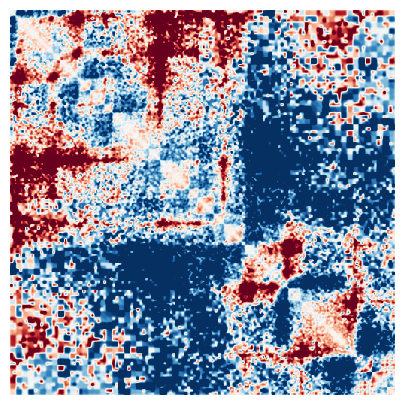

In [7]:
plot_map(kernel_log_hic_obsexp, vmin=-0.6, vmax=0.6)